# Libraries

In [1]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import optuna
import xgboost as xgb

import os
import joblib

# Load Dataset

In [3]:
df = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/CLASSIFICATION/Extrovert vs. Introvert Behavior Prediction/ML/Data/personality_dataset.csv')

# Data Information

In [4]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [6]:
obj = [col for col in df.columns if df[col].nunique() <= 10]
for col in obj:
   print(f"Column: {col}")
   print(f"Number of Unique Values (nunique): {df[col].nunique()}")
   print(f"Unique Values: {df[col].unique()}")
   print("Value Counts:")
   print(df[col].value_counts())
   print("-" * 50)

Column: Stage_fear
Number of Unique Values (nunique): 2
Unique Values: ['No' 'Yes' nan]
Value Counts:
Stage_fear
No     1417
Yes    1410
Name: count, dtype: int64
--------------------------------------------------
Column: Going_outside
Number of Unique Values (nunique): 8
Unique Values: [ 6.  0.  2.  7.  4.  5. nan  3.  1.]
Value Counts:
Going_outside
0.0    498
2.0    456
1.0    429
5.0    374
4.0    359
6.0    335
3.0    209
7.0    174
Name: count, dtype: int64
--------------------------------------------------
Column: Drained_after_socializing
Number of Unique Values (nunique): 2
Unique Values: ['No' 'Yes' nan]
Value Counts:
Drained_after_socializing
No     1441
Yes    1407
Name: count, dtype: int64
--------------------------------------------------
Column: Personality
Number of Unique Values (nunique): 2
Unique Values: ['Extrovert' 'Introvert']
Value Counts:
Personality
Extrovert    1491
Introvert    1409
Name: count, dtype: int64
--------------------------------------------------


# Data Cleaning

In [7]:
cols = [col for col in df.columns if df[col].isnull().sum() and col not in ['Stage_fear', 'Drained_after_socializing']]

for col in cols:
    df[col] = df[col].fillna(df[col].mean())

In [8]:
cols2 = ['Stage_fear', 'Drained_after_socializing']
for col1 in cols2:
    df[col1] = df[col1].fillna(df[col1].mode()[0])

In [17]:
def stage_fear_and_drained_after_socializing_mapping(val):
    if val == 'Yes':
        return 1
    elif val == 'No':
        return 0
    return np.nan

def personality_mapping(val):
    if val == 'Introvert':
        return 0
    elif val == 'Extrovert':
        return 1
    return np.nan

In [18]:
df['Stage_fear'] = df['Stage_fear'].apply(stage_fear_and_drained_after_socializing_mapping)
df['Drained_after_socializing'] = df['Drained_after_socializing'].apply(stage_fear_and_drained_after_socializing_mapping)
df['Personality'] = df['Personality'].apply(personality_mapping)

In [16]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,NaN,4.0,6.0,0,13.0,5.0,Extrovert
1,9.0,NaN,0.0,0.0,1,0.0,3.0,Introvert
2,9.0,NaN,1.0,2.0,1,5.0,2.0,Introvert
3,0.0,NaN,6.0,7.0,0,14.0,8.0,Extrovert
4,3.0,NaN,9.0,4.0,0,8.0,5.0,Extrovert


# Data Modeling

## Train Test Split

In [19]:
features = [col for col in df.columns if col not in ['Personality']]
target = 'Personality'

In [21]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Cross Validation

In [22]:
def crossval(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)

        print(f"Fold {fold + 1}: Accuracy: {score:.4f}")
        scores.append(score)

    avg_score = np.mean(scores)
    print(f"Average Accuracy: {avg_score:.4f}")
    return scores

## Hyperparameter

In [23]:
def objective_xgb(trial):
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'eval_metric': 'error',
        'verbosity': 0,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**xgb_params)
    scores = crossval(model, X, y)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=10)

best_learning_rate = study.best_params['learning_rate']

[I 2025-06-27 16:49:40,589] A new study created in memory with name: no-name-2d514365-b872-4b76-9ac5-243de7c0e779


Fold 1: Accuracy: 0.8897
Fold 2: Accuracy: 0.9241
Fold 3: Accuracy: 0.9000
Fold 4: Accuracy: 0.8966
Fold 5: Accuracy: 0.8966
Fold 6: Accuracy: 0.9379
Fold 7: Accuracy: 0.9207


[I 2025-06-27 16:49:41,648] Trial 0 finished with value: 0.9093103448275862 and parameters: {'learning_rate': 0.606382408051788}. Best is trial 0 with value: 0.9093103448275862.


Fold 8: Accuracy: 0.9069
Fold 9: Accuracy: 0.9138
Fold 10: Accuracy: 0.9069
Average Accuracy: 0.9093
Fold 1: Accuracy: 0.9345
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9103
Fold 4: Accuracy: 0.9138
Fold 5: Accuracy: 0.9172
Fold 6: Accuracy: 0.9448
Fold 7: Accuracy: 0.9276
Fold 8: Accuracy: 0.9172
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:49:42,396] Trial 1 finished with value: 0.9272413793103448 and parameters: {'learning_rate': 0.1577164970495618}. Best is trial 1 with value: 0.9272413793103448.


Fold 10: Accuracy: 0.9310
Average Accuracy: 0.9272
Fold 1: Accuracy: 0.9069
Fold 2: Accuracy: 0.9241
Fold 3: Accuracy: 0.9069
Fold 4: Accuracy: 0.9034
Fold 5: Accuracy: 0.9069
Fold 6: Accuracy: 0.9379
Fold 7: Accuracy: 0.9207
Fold 8: Accuracy: 0.9138


[I 2025-06-27 16:49:43,258] Trial 2 finished with value: 0.9158620689655173 and parameters: {'learning_rate': 0.3655395779299451}. Best is trial 1 with value: 0.9272413793103448.


Fold 9: Accuracy: 0.9276
Fold 10: Accuracy: 0.9103
Average Accuracy: 0.9159
Fold 1: Accuracy: 0.8828
Fold 2: Accuracy: 0.9172
Fold 3: Accuracy: 0.9069
Fold 4: Accuracy: 0.8931
Fold 5: Accuracy: 0.8931
Fold 6: Accuracy: 0.9379
Fold 7: Accuracy: 0.9069


[I 2025-06-27 16:49:44,071] Trial 3 finished with value: 0.9044827586206896 and parameters: {'learning_rate': 0.8797613017832953}. Best is trial 1 with value: 0.9272413793103448.


Fold 8: Accuracy: 0.9034
Fold 9: Accuracy: 0.9069
Fold 10: Accuracy: 0.8966
Average Accuracy: 0.9045
Fold 1: Accuracy: 0.9207
Fold 2: Accuracy: 0.9345
Fold 3: Accuracy: 0.9138
Fold 4: Accuracy: 0.9172
Fold 5: Accuracy: 0.9103
Fold 6: Accuracy: 0.9448
Fold 7: Accuracy: 0.9241
Fold 8: Accuracy: 0.9138
Fold 9: Accuracy: 0.9414


[I 2025-06-27 16:49:44,811] Trial 4 finished with value: 0.9241379310344826 and parameters: {'learning_rate': 0.21101254656321317}. Best is trial 1 with value: 0.9272413793103448.


Fold 10: Accuracy: 0.9207
Average Accuracy: 0.9241
Fold 1: Accuracy: 0.8931
Fold 2: Accuracy: 0.9241
Fold 3: Accuracy: 0.9034
Fold 4: Accuracy: 0.8897
Fold 5: Accuracy: 0.8931
Fold 6: Accuracy: 0.9345
Fold 7: Accuracy: 0.9103
Fold 8: Accuracy: 0.9000


[I 2025-06-27 16:49:45,660] Trial 5 finished with value: 0.9048275862068966 and parameters: {'learning_rate': 0.8131132740888823}. Best is trial 1 with value: 0.9272413793103448.


Fold 9: Accuracy: 0.9069
Fold 10: Accuracy: 0.8931
Average Accuracy: 0.9048
Fold 1: Accuracy: 0.9379
Fold 2: Accuracy: 0.9345
Fold 3: Accuracy: 0.9103
Fold 4: Accuracy: 0.9138
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9310


[I 2025-06-27 16:49:46,496] Trial 6 finished with value: 0.93 and parameters: {'learning_rate': 0.1346206863660373}. Best is trial 6 with value: 0.93.


Fold 8: Accuracy: 0.9138
Fold 9: Accuracy: 0.9483
Fold 10: Accuracy: 0.9379
Average Accuracy: 0.9300
Fold 1: Accuracy: 0.9000
Fold 2: Accuracy: 0.9207
Fold 3: Accuracy: 0.9034
Fold 4: Accuracy: 0.8931
Fold 5: Accuracy: 0.8897
Fold 6: Accuracy: 0.9310
Fold 7: Accuracy: 0.9138
Fold 8: Accuracy: 0.9034
Fold 9: Accuracy: 0.9069


[I 2025-06-27 16:49:47,358] Trial 7 finished with value: 0.9062068965517242 and parameters: {'learning_rate': 0.6010203772175069}. Best is trial 6 with value: 0.93.


Fold 10: Accuracy: 0.9000
Average Accuracy: 0.9062
Fold 1: Accuracy: 0.8966
Fold 2: Accuracy: 0.9138
Fold 3: Accuracy: 0.9103
Fold 4: Accuracy: 0.8897
Fold 5: Accuracy: 0.9000
Fold 6: Accuracy: 0.9345
Fold 7: Accuracy: 0.9103
Fold 8: Accuracy: 0.9034


[I 2025-06-27 16:49:48,196] Trial 8 finished with value: 0.9062068965517242 and parameters: {'learning_rate': 0.8193251647852441}. Best is trial 6 with value: 0.93.


Fold 9: Accuracy: 0.9103
Fold 10: Accuracy: 0.8931
Average Accuracy: 0.9062
Fold 1: Accuracy: 0.8862
Fold 2: Accuracy: 0.9241
Fold 3: Accuracy: 0.9034
Fold 4: Accuracy: 0.8897
Fold 5: Accuracy: 0.8966
Fold 6: Accuracy: 0.9310
Fold 7: Accuracy: 0.9207


[I 2025-06-27 16:49:49,088] Trial 9 finished with value: 0.9075862068965517 and parameters: {'learning_rate': 0.7202884656955362}. Best is trial 6 with value: 0.93.


Fold 8: Accuracy: 0.9103
Fold 9: Accuracy: 0.9172
Fold 10: Accuracy: 0.8966
Average Accuracy: 0.9076


In [24]:
def objective_xgb_params(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': best_learning_rate,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'random_state': 42,
        'eval_metric': 'error',
        'verbosity': 0,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**xgb_params)
    scores = crossval(model, X, y)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb_params, n_trials=10)

best_params = study.best_params

[I 2025-06-27 16:49:49,732] A new study created in memory with name: no-name-7c910b25-4301-476f-aa2f-39a63f8c9294


Fold 1: Accuracy: 0.9379
Fold 2: Accuracy: 0.9345
Fold 3: Accuracy: 0.9172
Fold 4: Accuracy: 0.9207
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9448
Fold 7: Accuracy: 0.9310
Fold 8: Accuracy: 0.9103
Fold 9: Accuracy: 0.9483


[I 2025-06-27 16:49:54,726] Trial 0 finished with value: 0.9310344827586207 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.34087861351299303, 'colsample_bytree': 0.9502706524205209, 'n_estimators': 737}. Best is trial 0 with value: 0.9310344827586207.


Fold 10: Accuracy: 0.9414
Average Accuracy: 0.9310
Fold 1: Accuracy: 0.9414
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9207
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9310
Fold 8: Accuracy: 0.9172


[I 2025-06-27 16:49:55,996] Trial 1 finished with value: 0.9337931034482759 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6261506248217957, 'colsample_bytree': 0.3089214120686141, 'n_estimators': 164}. Best is trial 1 with value: 0.9337931034482759.


Fold 9: Accuracy: 0.9517
Fold 10: Accuracy: 0.9483
Average Accuracy: 0.9338
Fold 1: Accuracy: 0.9345
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9138
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9172
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:49:58,563] Trial 2 finished with value: 0.9324137931034482 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.19073454049403055, 'colsample_bytree': 0.6921491083058726, 'n_estimators': 671}. Best is trial 1 with value: 0.9337931034482759.


Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9324
Fold 1: Accuracy: 0.9414
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9207
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9172
Fold 9: Accuracy: 0.9517


[I 2025-06-27 16:50:03,222] Trial 3 finished with value: 0.9344827586206895 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.31570009277304334, 'colsample_bytree': 0.5090260304392022, 'n_estimators': 877}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9345
Fold 1: Accuracy: 0.9345
Fold 2: Accuracy: 0.9414
Fold 3: Accuracy: 0.9172
Fold 4: Accuracy: 0.9103
Fold 5: Accuracy: 0.9276
Fold 6: Accuracy: 0.9414
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9069
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:50:06,308] Trial 4 finished with value: 0.9289655172413793 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7214351481701492, 'colsample_bytree': 0.4829257264816473, 'n_estimators': 417}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9310
Average Accuracy: 0.9290
Fold 1: Accuracy: 0.9345
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9138
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9207
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9103
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:50:08,582] Trial 5 finished with value: 0.9313793103448276 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.911070944839088, 'colsample_bytree': 0.28217802875671705, 'n_estimators': 368}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9314
Fold 1: Accuracy: 0.9379
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9069
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9172


[I 2025-06-27 16:50:10,356] Trial 6 finished with value: 0.9327586206896552 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.18001724065673738, 'colsample_bytree': 0.18617632377840854, 'n_estimators': 428}. Best is trial 3 with value: 0.9344827586206895.


Fold 9: Accuracy: 0.9517
Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9328
Fold 1: Accuracy: 0.9414
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9207
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9172
Fold 9: Accuracy: 0.9517


[I 2025-06-27 16:50:13,085] Trial 7 finished with value: 0.9344827586206895 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.5343176993822029, 'colsample_bytree': 0.8329638942261902, 'n_estimators': 491}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9345
Fold 1: Accuracy: 0.9379
Fold 2: Accuracy: 0.9310
Fold 3: Accuracy: 0.9138
Fold 4: Accuracy: 0.9241
Fold 5: Accuracy: 0.9207
Fold 6: Accuracy: 0.9483
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9069
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:50:15,608] Trial 8 finished with value: 0.9313793103448276 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7592392448931411, 'colsample_bytree': 0.12935556223284983, 'n_estimators': 546}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9517
Average Accuracy: 0.9314
Fold 1: Accuracy: 0.9345
Fold 2: Accuracy: 0.9414
Fold 3: Accuracy: 0.9172
Fold 4: Accuracy: 0.9172
Fold 5: Accuracy: 0.9241
Fold 6: Accuracy: 0.9414
Fold 7: Accuracy: 0.9345
Fold 8: Accuracy: 0.9103
Fold 9: Accuracy: 0.9448


[I 2025-06-27 16:50:19,503] Trial 9 finished with value: 0.9296551724137931 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9370003367532713, 'colsample_bytree': 0.5380890411206996, 'n_estimators': 609}. Best is trial 3 with value: 0.9344827586206895.


Fold 10: Accuracy: 0.9310
Average Accuracy: 0.9297


In [25]:
final_XGB_params = {
    'max_depth': best_params['max_depth'],
    'learning_rate': best_learning_rate,
    'n_estimators': best_params['n_estimators'],
    'min_child_weight': best_params['min_child_weight'],
    'colsample_bytree': best_params['colsample_bytree'],
    'subsample': best_params['subsample'],
    'eval_metric': 'auc',
    'random_state': 42,
    'verbosity': 2,
    'n_jobs': -1
}

final_model = xgb.XGBClassifier(**final_XGB_params)
scores = crossval(model=final_model, X=X, y=y)

[16:50:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2610, 7, 13050).
[16:50:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (290, 7, 1450).
Fold 1: Accuracy: 0.9414
[16:50:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2610, 7, 13050).
[16:50:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (290, 7, 1450).
Fold 2: Accuracy: 0.9310
[16:50:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2610, 7, 13050).
[16:50:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (290, 7, 1450).
Fold 3: Accuracy: 0.9207
[

C:\Users\firma\AppData\Local\Temp\ipykernel_17936\2054834927.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


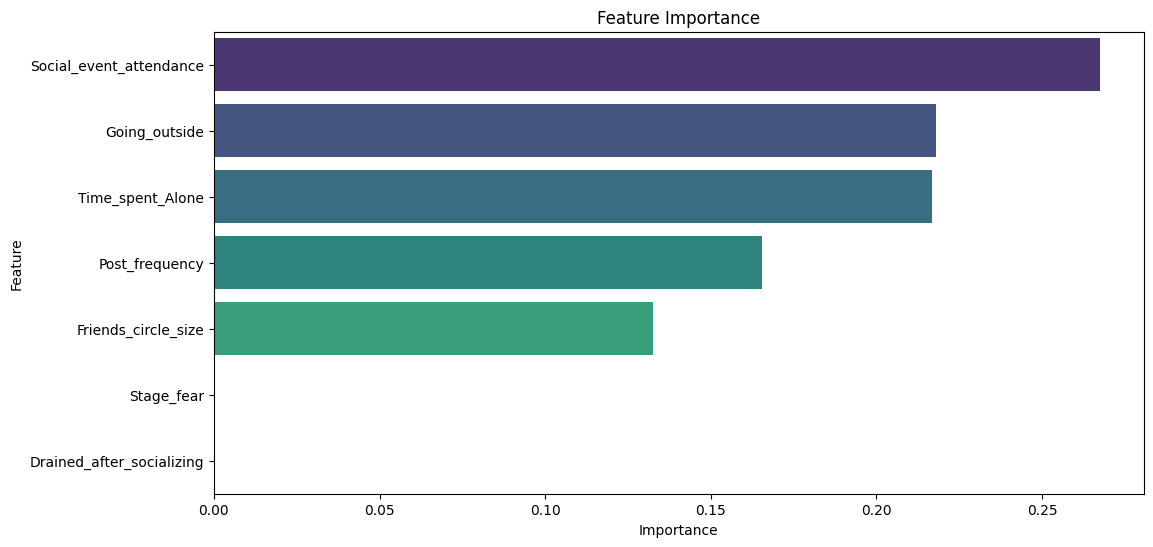

In [28]:
feature_importance = final_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Model Evaluation

[16:50:58] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2320, 7, 11600).
Test Accuracy: 0.9241

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       282
           1       0.94      0.91      0.93       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



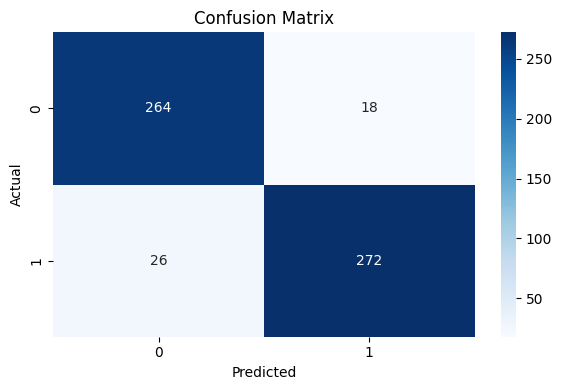

In [29]:
model = xgb.XGBClassifier(**final_XGB_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [30]:
target_path = "../Model/introvert_vs_extrovert_behavior.pkl"
os.makedirs("../Model", exist_ok=True)
joblib.dump(model, target_path)

['../Model/introvert_vs_extrovert_behavior.pkl']